# Give about 3-5 minutes for code to compile

# Functions Set Up

In [1]:
import numpy as np

np.seterr(divide = 'ignore')
def layer(dim_in,dim_out, activation):
    # dictionary to hold all the different attributes for a layer
    layer = {}
    
    # number weights is = number of neurons in the previos layer * number of neurons in this layer
    # initialised as random floats from -1 -> 1 
    layer['weights'] = 0.1*np.random.randn(dim_in, dim_out)
    
    # One Bias for each neuron
    layer['biases'] = np.zeros((1,dim_out))
    
    # Activation function for this layer (if Linear then no effect, one to one linear mapping)
    layer['activation'] = activation
    
    # Initialise momentums and caches as zero
    layer['mweight'] = np.zeros_like(layer['weights'])
    layer['cweight'] = np.zeros_like(layer['weights'])
    layer['mbias'] = np.zeros_like(layer['biases'])
    layer['cbias'] = np.zeros_like(layer['biases'])
        
    return layer


def forward_layer(layer, inputs):
    # Save inputs for later backpropogation
    layer['inputs'] = inputs
    
    # Calculate output of each neuron in the layer
    layer['outputs'] = np.dot(layer['inputs'],layer['weights']) + layer['biases']
    
    # Impose activation if available
    if layer['activation'] == 'Relu':
        
        layer['activation_inputs'] = layer['outputs']
        
        # Non linear Relu Activation
        layer['activation_outputs'] = np.maximum(0,layer['outputs'])
        
    return layer


def backward_layer(layer, backprop):
    
    # Values from previous layer back propogated (loss function values for the final layer)
    layer['backprop_inputs'] = backprop.copy()
    
    # Work backwards to get Relu values
    if layer['activation'] == 'Relu':
        layer['backprop_inputs'][layer['activation_inputs'] <= 0] = 0
   
    # Backprop weights and biases changes, derived from partial derivatives as in paper
    layer['bweights'] = np.dot(layer['inputs'].T, layer['backprop_inputs'])
    layer['bbiases'] = np.sum(layer['backprop_inputs'],axis = 0, keepdims = True)
    layer['backprop_inputs'] = np.dot(layer['backprop_inputs'], layer['weights'].T)
    
    
        
    return layer

def loss_forward(prediction, desired):
    # Calculate loss on the forward pass
    return np.mean(np.mean((prediction-desired)**2, axis = 1))

def loss_backward(backprop,desired):
    # Calculate partial derivative of loss with respect to output, as in paper
    return (-2*(desired - backprop)/ len(backprop[0]))/len(backprop)
        

# Set Adam Optimizer Hyperparamters
def optimizer_setup(A,A_decay):
    optimizer = {}
    
    # Alpha (ie learning rate)
    optimizer['A'] = A
    
    # Alpha correct
    optimizer['A_decay'] = A_decay
     
    # Beta 1 and 2
    optimizer['B1'] = 0.9
    optimizer['B2'] = 0.999
    
    return optimizer
        
# Adamn Method for Optimization Schochastic Gradient Descent
def optimizer_adjust(optimizer, layer):
    
    # Momentums of weights and biases
    layer['mweight'] = optimizer['B1'] * layer['mweight'] + (1 - optimizer['B1']) * layer['bweights']
    layer['mbias'] = optimizer['B1'] * layer['mbias'] + (1 - optimizer['B1']) * layer['bbiases']
    
    # Adjustement and correct of momentum of weights and biases
    mweight_corrected = layer['mweight'] / (1 - optimizer['B1'] ** (optimizer['epoch'] + 1))
    mbias_corrected = layer['mbias'] / (1 - optimizer['B1'] ** (optimizer['epoch'] + 1))

    # Cache of weight and biases
    layer['cweight'] = optimizer['B2'] * layer['cweight'] + (1 - optimizer['B2']) * layer['bweights']**2
    layer['cbias'] = optimizer['B2'] * layer['cbias'] + (1 - optimizer['B2']) * layer['bbiases']**2

    # Adjustement and correct of cache of weights and biases
    cweight_corrected = layer['cweight'] / (1 - optimizer['B2'] ** (optimizer['epoch'] + 1))
    cbias_corrected = layer['cbias'] / (1 - optimizer['B2'] ** (optimizer['epoch'] + 1))

    # Adjust weights and biases 
    layer['weights'] += -optimizer['A'] * mweight_corrected / (np.sqrt(cweight_corrected) + 1e-8)
    layer['biases'] += -optimizer['A'] * mbias_corrected / (np.sqrt(cbias_corrected) + 1e-8)
    
    return layer


# Data generation and training of model to perform root finding (Quadratic Eq)

## 1. Only the Maximal Real Solution

In [2]:
np.random.seed(42)

### Training data

# Inputs
X = []

# Desired Outputs
y = []

for i in range(3000):
    # Generate three random a,b,c and d to represnt a third order polynomial of the form:
    # ax**3 + bx**2 + c + d
    sign = sign2 = -1
    if np.random.randint(2) == 1:sign = 1
    if np.random.randint(2) == 1:sign2 = 1
        
    a = sign2*np.random.randint(100)
    b = np.random.randint(100)
    c = sign*np.random.randint(100)
    
    # Find solutions, and save the maximum real solution if it exists
    sol = np.roots([a,b,c])
    sol = np.array([i for i in sol if i.imag == 0])
    if sol.any():
        X.append([a,b,c])
        y.append([max(sol)])    

### Testing data   

# Same as training data but additional line of code to discard any values that were in the training set
# All testing data points have not been trained on
Xtest = []
ytest = []
for i in range(1000):
    sign = sign2 = -1
    if np.random.randint(2) == 1:sign = 1
    if np.random.randint(2) == 1:sign2 = 1
        
    a = sign2*np.random.randint(100)
    b = np.random.randint(100)
    c = sign*np.random.randint(100)

    sol = np.roots([a,b,c])
    sol = np.array([i for i in sol if i.imag == 0])
    if sol.any():
        Xtest.append([a,b,c])
        ytest.append([max(sol)])    


    
X = np.array(X)
y = np.array(y)

Xtest = np.array(Xtest)
ytest = np.array(ytest)


# Initialising the three layers of the neural network
layer1 = layer(3, 64, 'Relu')

layer2 = layer(64, 64, 'Relu')

layer3 = layer(64, 1, 'Linear')



# Initialise optimizer with an Alpha of 0.005 and a decay of 1e-4
A = 0.01
optimizer = optimizer_setup(A,1e-3)
optimizer['epoch'] = 0

models = []
# Train on data for 10 000 epochs
for epoch in range(10000):

    # Forward pass of dara
    layer1 = forward_layer(layer1,X)


    layer2 = forward_layer(layer2,layer1['activation_outputs'])

    layer3 = forward_layer(layer3,layer2['activation_outputs'])
    

    # Forward pass loss calculation
    loss = loss_forward(layer3['outputs'], y)


    if epoch % 500 == 0:
        # Custom accuracy metric, percent accuracy represents how much the prediction p
        # Is off the desired output y as a percentage of y. ( eg. p = 3, y = 2 =>  accuracy is 50 percent)
        
        y_flat = y.flatten()
        pred_flat = layer3['outputs'].flatten()
        accuracies = [abs((y_flat[i]-pred_flat[i])/y_flat[i] )*100 for i in range(len(y_flat))]
        off_point = np.mean([i for i in accuracies if i!= np.inf and i<500])
        
        # If prediction is more than twice the value of the desired output, accuracy is 0 percent
        if off_point > 100:
            accuracy = 0
        else:
            accuracy = 100 - off_point
            
        print(f'accuracy: {accuracy: 4f}, ' +  f'loss: {loss:.10f} ' + f'epoch: {epoch}, ' )
        
    
    
    # Backwards pass
    backprop = loss_backward(layer3['outputs'], y)
    layer3 = backward_layer(layer3, backprop)
    layer2 = backward_layer(layer2,layer3['backprop_inputs'])
    layer1 = backward_layer(layer1,layer2['backprop_inputs'])
 
    
    # Optimize backprop values using Adam
    optimizer['A'] = A * (1 / (1 + optimizer['A_decay'] * optimizer['epoch']))
    
    layer1 =  optimizer_adjust(optimizer, layer1)

    layer2 = optimizer_adjust(optimizer, layer2)
    layer3 = optimizer_adjust(optimizer, layer3)
    
    optimizer['epoch'] = epoch + 1

accuracy:  0.000000, loss: 54.0832467355 epoch: 0, 
accuracy:  59.363817, loss: 0.1481390147 epoch: 500, 
accuracy:  85.596009, loss: 0.0404137507 epoch: 1000, 
accuracy:  87.510418, loss: 0.0246244520 epoch: 1500, 
accuracy:  89.470197, loss: 0.0154112073 epoch: 2000, 
accuracy:  86.142440, loss: 0.0159828169 epoch: 2500, 
accuracy:  91.242511, loss: 0.0081319528 epoch: 3000, 
accuracy:  92.113385, loss: 0.0058680021 epoch: 3500, 
accuracy:  86.465782, loss: 0.0086398589 epoch: 4000, 
accuracy:  92.682828, loss: 0.0043665254 epoch: 4500, 
accuracy:  93.268304, loss: 0.0036131492 epoch: 5000, 
accuracy:  87.858951, loss: 0.0054055389 epoch: 5500, 
accuracy:  93.102653, loss: 0.0028419947 epoch: 6000, 
accuracy:  88.840616, loss: 0.0037432695 epoch: 6500, 
accuracy:  93.724838, loss: 0.0022123446 epoch: 7000, 
accuracy:  94.107717, loss: 0.0019268412 epoch: 7500, 
accuracy:  94.002279, loss: 0.0017903021 epoch: 8000, 
accuracy:  91.283885, loss: 0.0026007378 epoch: 8500, 
accuracy:  93.

In [3]:
import pandas as pd
# Forward pass of test values through the neural network
layer1 = forward_layer(layer1,Xtest)
layer2 = forward_layer(layer2,layer1['activation_outputs'])
layer3 = forward_layer(layer3,layer2['activation_outputs'])

###
#### Calculate test accuracy
y_flat = ytest.flatten()
pred_flat = layer3['outputs'].flatten()
accuracies = [abs((y_flat[i]-pred_flat[i])/y_flat[i] )*100 for i in range(len(y_flat))]
off_point = np.mean([i for i in accuracies if i!= np.inf and i<500])

# If prediction is more than twice the value of the desired output, accuracy is 0 percent
if off_point > 100:
    accuracy = 0
else:
    accuracy = 100 - off_point

print('Accuracy on test set:' , accuracy)


###
test = pd.DataFrame()
# Print test values and predicted values side by side to get an idea of how accurate the model is

test['Solution Real Numpy Test Set'] = [ str(i)[:5] for i in ytest.flatten()]
test['Solution Real Model Test Set'] = [ str(i)[1:6] for i in layer3['outputs'] ]

test

Accuracy on test set: 91.31690142232992


,Solution Real Numpy Test Set,Solution Real Model Test Set
0,1.999,2.042
1,2.217,2.242
2,4.142,4.078
3,-0.29,-0.31
4,0.839,0.823
...,...,...
638,0.790,0.791
639,-0.02,-0.03
640,12.45,12.24
641,0.271,0.206


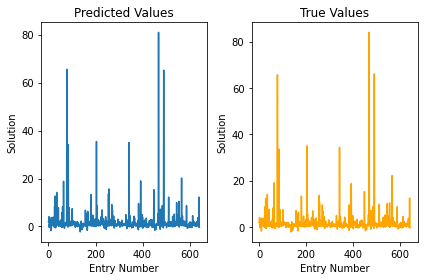

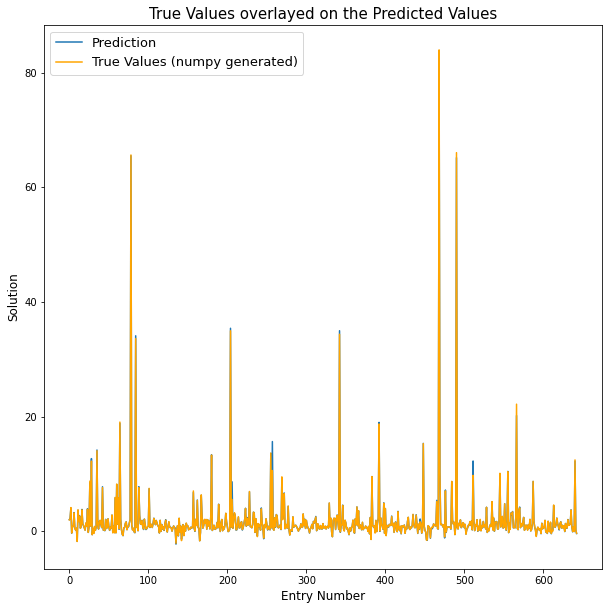

In [4]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('Predicted Values')
ax1.plot(layer3['outputs'], label = 'Prediction')
ax1.set_ylabel('Solution')
ax1.set_xlabel('Entry Number')
ax2.plot(ytest, label = 'True Values (numpy generated)', color = 'orange')
ax2.set_title('True Values')
ax2.set_ylabel('Solution')
ax2.set_xlabel('Entry Number')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.title('True Values overlayed on the Predicted Values', fontsize = '15')
plt.plot(layer3['outputs'], label = 'Prediction')
plt.plot(ytest, label = 'True Values (numpy generated)', color = 'orange')
plt.xlabel('Entry Number',fontsize = '12')
plt.ylabel('Solution',fontsize = '12')
plt.legend(fontsize = '13')
plt.show()


## 2. All solutions, real and imaginary

In [5]:
np.random.seed(42)

### Training data

# Inputs
X = []

# Desired Outputs
y = []

for i in range(3000):
    # Generate three random a,b,c and d to represnt a third order polynomial of the form:
    # ax**3 + bx**2 + c + d
    sign = sign2 = -1
    if np.random.randint(2) == 1:sign = 1
    if np.random.randint(2) == 1:sign2 = 1
        
    a = sign2*np.random.randint(100)
    b = np.random.randint(100)
    c = sign*np.random.randint(100)
    
    # Find solutions, and save the maximum real solution if it exists
    sol = np.roots([a,b,c])
    if sol.any():
        if len(sol) == 1:
            sol = np.array([sol[0],sol[0]])
        X.append([a,b,c])
        y.append([sol[0].real,sol[0].imag,sol[1].real,sol[1].imag])    

### Testing data   

# Same as training data but additional line of code to discard any values that were in the training set
# All testing data points have not been trained on
Xtest = []
ytest = []
for i in range(1000):
    sign = sign2 = -1
    if np.random.randint(2) == 1:sign = 1
    if np.random.randint(2) == 1:sign2 = 1
        
    a = sign2*np.random.randint(100)
    b = np.random.randint(100)
    c = sign*np.random.randint(100)

    sol = np.roots([a,b,c])
    if sol.any():
        if len(sol) == 1:
            sol = np.array([sol[0],sol[0]])
        Xtest.append([a,b,c])
        ytest.append([sol[0].real,sol[0].imag,sol[1].real,sol[1].imag])    

    
X = np.array(X)
y = np.array(y)

Xtest = np.array(Xtest)
ytest = np.array(ytest)


# Initialising the three layers of the neural network
layer1 = layer(3, 64, 'Relu')

layer2 = layer(64, 64, 'Relu')

layer3 = layer(64, 4, 'Linear')




# Initialise optimizer with an Alpha of 0.005 and a decay of 1e-4
A = 0.01
optimizer = optimizer_setup(A,1e-4)
optimizer['epoch'] = 0


# Train on data for 10 000 epochs
for epoch in range(10000):

    # Forward pass of dara
    layer1 = forward_layer(layer1,X)


    layer2 = forward_layer(layer2,layer1['activation_outputs'])

    layer3 = forward_layer(layer3,layer2['activation_outputs'])
    
    
    
    

    # Forward pass loss calculation
    loss = loss_forward(layer3['outputs'], y)


    if epoch % 500 == 0:
        # Custom accuracy metric, percent accuracy represents how much the prediction p
        # Is off the desired output y as a percentage of y. ( eg. p = 3, y = 2 =>  accuracy is 50 percent)
        
        y_flat = y.flatten()
        pred_flat = layer3['outputs'].flatten()
        accuracies = [abs((y_flat[i]-pred_flat[i])/y_flat[i] )*100 for i in range(len(y_flat))]
        off_point = np.mean([i for i in accuracies if i!= np.inf and i<500])
        
        # If prediction is more than twice the value of the desired output, accuracy is 0 percent
        if off_point > 100:
            accuracy = 0
        else:
            accuracy = 100 - off_point
            
        print(f'accuracy: {accuracy: 4f}, ' +  f'loss: {loss:.10f} ' + f'epoch: {epoch}, ' )
        
    
    
    # Backwards pass
    backprop = loss_backward(layer3['outputs'], y)
    layer3 = backward_layer(layer3, backprop)
    layer2 = backward_layer(layer2,layer3['backprop_inputs'])
    layer1 = backward_layer(layer1,layer2['backprop_inputs'])
 
    
    # Optimize backprop values using Adam
    optimizer['A'] = A * (1 / (1 + optimizer['A_decay'] * optimizer['epoch']))
    
    layer1 =  optimizer_adjust(optimizer, layer1)

    layer2 = optimizer_adjust(optimizer, layer2)
    layer3 = optimizer_adjust(optimizer, layer3)
    
    optimizer['epoch'] = epoch + 1
    


accuracy:  0.000000, loss: 23.8292566489 epoch: 0, 
accuracy:  62.852630, loss: 0.1402814530 epoch: 500, 
accuracy:  79.157736, loss: 0.0446391777 epoch: 1000, 
accuracy:  75.693505, loss: 0.0343924944 epoch: 1500, 
accuracy:  79.236166, loss: 0.0260807345 epoch: 2000, 
accuracy:  79.872447, loss: 0.0207501945 epoch: 2500, 
accuracy:  83.224281, loss: 0.0173670182 epoch: 3000, 
accuracy:  74.547569, loss: 0.0246267206 epoch: 3500, 
accuracy:  85.337212, loss: 0.0113017581 epoch: 4000, 
accuracy:  82.464979, loss: 0.0142833977 epoch: 4500, 
accuracy:  83.112149, loss: 0.0118461472 epoch: 5000, 
accuracy:  75.466379, loss: 0.0222309096 epoch: 5500, 
accuracy:  82.103417, loss: 0.0104194942 epoch: 6000, 
accuracy:  86.355721, loss: 0.0102602727 epoch: 6500, 
accuracy:  81.095168, loss: 0.0119775951 epoch: 7000, 
accuracy:  83.962415, loss: 0.0084127171 epoch: 7500, 
accuracy:  81.900301, loss: 0.0128464078 epoch: 8000, 
accuracy:  85.787410, loss: 0.0068173189 epoch: 8500, 
accuracy:  88.

# Test Values

In [6]:
# Forward pass of test values through the neural network
layer1 = forward_layer(layer1,Xtest)
layer2 = forward_layer(layer2,layer1['activation_outputs'])
layer3 = forward_layer(layer3,layer2['activation_outputs'])

###
#### Calculate test accuracy
y_flat = ytest.flatten()
pred_flat = layer3['outputs'].flatten()
accuracies = [abs((y_flat[i]-pred_flat[i])/y_flat[i] )*100 for i in range(len(y_flat))]
off_point = np.mean([i for i in accuracies if i!= np.inf and i<500])

# If prediction is more than twice the value of the desired output, accuracy is 0 percent
if off_point > 100:
    accuracy = 0
else:
    accuracy = 100 - off_point
test

print('Accuracy on test set:' , accuracy)


test = pd.DataFrame()
# Print test values and predicted values side by side to get an idea of how accurate the model is

test['Solution 1 Real Numpy'] = [str(i[0])[:5] for i in ytest]
test['Solution 1 Real Model'] = [str(i[0])[:5]  for i in layer3['outputs'] ]
test['Solution 1 Imag Numpy'] = [str(i[1])[:5]  for i in ytest]
test['Solution 1 Imag Model'] = [str(i[1])[:5]  for i in layer3['outputs']]

test['Solution 2 Real Numpy'] = [str(i[2])[:5]  for i in ytest]
test['Solution 2 Real Model'] = [str(i[2])[:5]  for i in layer3['outputs'] ]
test['Solution 2 Imag Numpy'] = [str(i[3])[:5]  for i in ytest]
test['Solution 2 Imag Model'] = [str(i[3])[:5]  for i in layer3['outputs']]

#[[list(ytest[i]),list(layer3['outputs'][i])] for i in range(len(ytest))]
test

Accuracy on test set: 83.71822849511638


,Solution 1 Real Numpy,Solution 1 Real Model,Solution 1 Imag Numpy,Solution 1 Imag Model,Solution 2 Real Numpy,Solution 2 Real Model,Solution 2 Imag Numpy,Solution 2 Imag Model
0,1.999,1.902,0.0,-0.02,-0.62,-0.58,0.0,0.021
1,-0.19,-0.24,1.154,1.105,-0.19,-0.23,-1.15,-1.10
2,2.217,1.994,0.0,0.005,-0.19,-0.13,0.0,-0.00
3,-0.41,-0.38,0.725,0.713,-0.41,-0.36,-0.72,-0.71
4,1.055,0.983,1.104,1.097,1.055,1.113,-1.10,-1.09
...,...,...,...,...,...,...,...,...
995,12.45,12.36,0.0,0.041,-0.83,-0.82,0.0,-0.04
996,0.895,0.894,0.444,0.524,0.895,0.851,-0.44,-0.52
997,0.204,0.107,0.935,0.914,0.204,0.268,-0.93,-0.91
998,-2.35,-2.38,0.0,0.000,0.271,0.269,0.0,-0.00


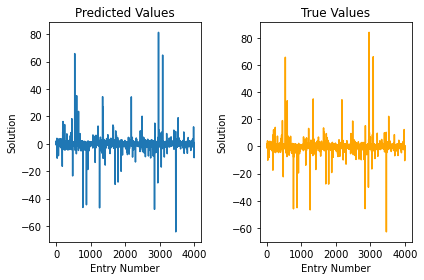

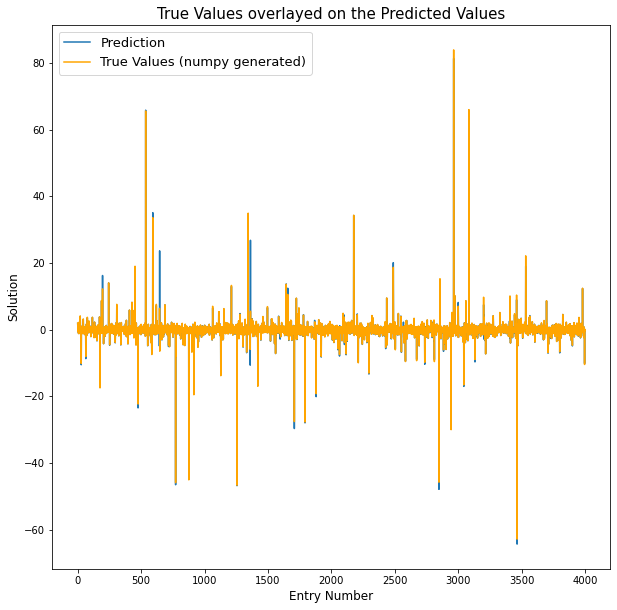

1000

In [7]:
# Forward pass through model
layer1 = forward_layer(layer1,Xtest)
layer2 = forward_layer(layer2,layer1['activation_outputs'])
layer3 = forward_layer(layer3,layer2['activation_outputs'])

# Flatten Predcitions and True values
# They are currently lists composed of lists with 4 elements each
ytest_flat = np.array(ytest).flatten()
prediction = layer3['outputs'].flatten()


fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot Predcitions and True values side by side
ax1.set_title('Predicted Values')
ax1.plot(prediction, label = 'Prediction')
ax1.set_ylabel('Solution')
ax1.set_xlabel('Entry Number')
ax2.plot(ytest_flat, label = 'True Values (numpy generated)', color = 'orange')
ax2.set_title('True Values')
ax2.set_ylabel('Solution')
ax2.set_xlabel('Entry Number')
plt.tight_layout()
plt.show()

# Overlay plots
plt.figure(figsize=(10,10))
plt.title('True Values overlayed on the Predicted Values', fontsize = '15')
plt.plot([i for i in range(len(prediction))] ,prediction , label = 'Prediction')
plt.plot([i for i in range(len(prediction))] ,ytest_flat, label = 'True Values (numpy generated)', color = 'orange')
plt.xlabel('Entry Number', fontsize = '12')
plt.ylabel('Solution', fontsize = '12')
plt.legend(fontsize = '13')
plt.show()
len(ytest)